In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

% matplotlib inline

In [2]:
data = pd.read_csv('Salary_Data.csv')

In [3]:
data.head()

,YearsExperience,Salary
0,1.1,39343.0
1,1.3,46205.0
2,1.5,37731.0
3,2.0,43525.0
4,2.2,39891.0


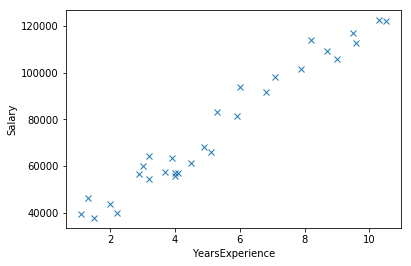

In [4]:
plt.plot(data['YearsExperience'], data['Salary'], 'x')
plt.xlabel('YearsExperience')
plt.ylabel('Salary')

Here we try to fit the model with simple linear regression model, which was given by the format:
$y = b_{1} x + b_{0}$

And our goal is to find the coefficient.

Given that our datasize is small, we could use the equation for calculating the coeffecient directly

$ R = \frac{\sum (X - X_{mean})(Y - Y_{mean})}{\sum (X-X_{mean})^2} =  \frac{\sum (X - X_{mean})(Y - Y_{mean})}{(n-1)X_{var}}$

In [5]:
b1 = np.dot((data['Salary']-data['Salary'].mean()), (data['YearsExperience'] - data['YearsExperience'].mean()))

In [6]:
# b1 = b1/(np.sum(np.square(data['YearsExperience'] - data['YearsExperience'].mean())))
b1 = b1/(data['YearsExperience'].var()*(len(data)-1))

In [7]:
b1

9449.9623214550757

In [8]:
residual = data['Salary'] - b1 * data['YearsExperience']

In [9]:
b0 = residual.mean()
b0

25792.200198668699

In [10]:
data['Salary_pred'] = b1 * data['YearsExperience'] + b0

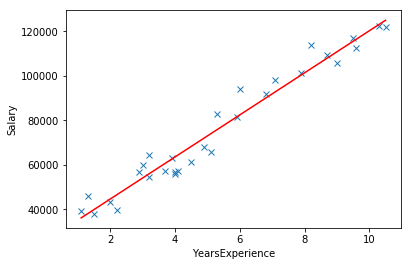

In [11]:
plt.plot(data['YearsExperience'], data['Salary'], 'x')
plt.plot(data['YearsExperience'], data['Salary_pred'],'r')
plt.xlabel('YearsExperience')
plt.ylabel('Salary')

However, if we do not know the solution to begin with, how will we get the coefficient. The method that is widely used to solve this kind of simple linear regression is called ordinary least square. The idea is to minimize the sum of square differences between the target data and fitted results.

In the following, we will use the ordinary least square method to obtain the coefficient and bias

In [12]:
# Obtain the dependent and independent data from the original variable
X = data['YearsExperience']
y = data['Salary']

In [13]:
# Split the data into training and testing set
from sklearn.model_selection import train_test_split

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=0)

In [14]:
from sklearn.linear_model import LinearRegression

In [15]:
regressor = LinearRegression()
regressor.fit(X=X_train.values.reshape(-1,1), y=y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [16]:
regressor.coef_

array([ 9345.94244312])

In [17]:
regressor.intercept_

26816.192244031183

In [18]:
y_pred = regressor.predict(X_test.values.reshape(-1,1))

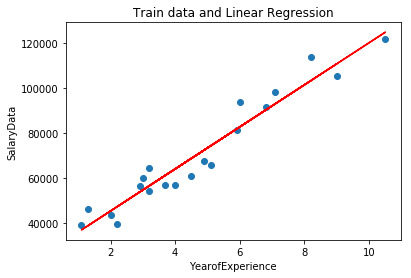

In [19]:
plt.scatter(X_train, y_train)
plt.plot(X_train, regressor.predict(X_train.values.reshape(-1,1)), 'r-')
plt.xlabel('YearofExperience')
plt.ylabel('SalaryData')
plt.title('Train data and Linear Regression')

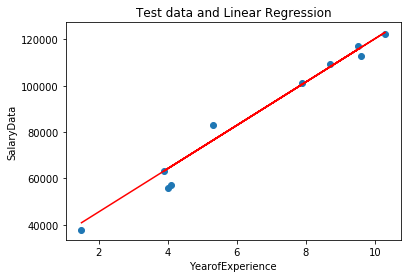

In [20]:
plt.scatter(X_test, y_test)
plt.plot(X_test, regressor.predict(X_test.values.reshape(-1,1)), 'r-')
plt.xlabel('YearofExperience')
plt.ylabel('SalaryData')
plt.title('Test data and Linear Regression')

We have fit the model with the ordinary least square method. But we now need to evaluate how accurate is our estimate on coefficient.

### Q1: What is the confidence intervals of our estimation of the parameters?

Here we will calculate the confidence interval for coefficient and intercept
We will compare the boot strapping method andc compare with the equation estimated results.

Define an arbitrary X, y relationship

$ y = \beta_{0} + \beta_{1}x = 26000 + 9400x$

In [170]:
# Pick up a sample of 100 number
X = np.arange(1,11,0.1).reshape(-1,1)
beta0 = 26000
beta1 = 9400
np.random.seed(0)
noise = np.random.normal(loc=0.0, scale=10000.0, size=(len(X),1))
y = beta0 + beta1 * X + noise

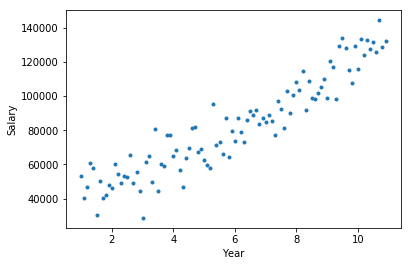

In [171]:
plt.plot(X, y, '.')
plt.xlabel('Year')
plt.ylabel('Salary')

In [172]:
samp_size = len(X)
samp_size

100

In [173]:
# fit with stats model
import statsmodels.api as sm

# Append the X with ones
X = np.concatenate((X, np.ones((samp_size,1))), axis=1)

In [174]:
regressor = sm.OLS(y,X).fit()

In [175]:
regressor.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     670.6
Date:                Tue, 19 Dec 2017   Prob (F-statistic):           1.27e-45
Time:                        18:43:35   Log-Likelihood:                -1063.3
No. Observations:                 100   AIC:                             2131.
Df Residuals:                      98   BIC:                             2136.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          9099.6698    351.396     25.896      0.000    8402.336    9797.003
const       2.839e+04   2323.866     12.215      0.000    2.38e+04     3.3e+04
==============================================================================
Omnibus:                        0.397   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.820   Jarque-Bera (JB):                0.556
Skew:                          -0.036   Prob(JB):                        0.757
Kurtosis:                       2.642   Cond. No.                         15.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the above results we could see that the statsmodels tool box has given us the 0.025 - 0.975 confidence interval estimation. We now needs to calculate by ourself to validate it and to strengthen our understanding.

In [176]:
# Using bootstraping
# 1. Draw m time of sample size n samples from the original sample with replacement
def bootstrap(X, y, m):
    """
    Perform bootstrap resampling from data sample X, m times
    ----------------------------------------------------------
    X: Independent values of sample drawn from the original distribution
    y: Dependent values of sample drawn from the original distribution
    m: number of bootstrapping
    """
    X_resamp = []
    y_resamp = []
    for _ in range(m):
        samp_idx = np.random.randint(0, len(X), len(X))
        X_resamp.append(X[samp_idx])
        y_resamp.append(y[samp_idx])
    
    return X_resamp, y_resamp

In [177]:
boot_X, boot_y = bootstrap(X, y, m=1000)

In [178]:
# 2. Perform regression on the m samples, obtain the coefficient and intercept
def bootstrap_fit(boot_X, boot_y):
    """
    Fit model on bootstraped dataset
    ------------------------------------
    bootstrap_X: list of bootstraped data
    """
    coef = []
    intercept = []
    
    for i in range(len(boot_X)):
        regressor = sm.OLS(boot_y[i],boot_X[i]).fit()
        coef.append(regressor.params[0])
        intercept.append(regressor.params[1])
        
    return coef, intercept

In [179]:
# 3. Obtain the distribution of the two parameters
coef, intercept = np.array(bootstrap_fit(boot_X, boot_y))

In [180]:
# 4. Use mean and standard deviation to estimate the standard error of the estimate of the sample parameter
coef_std = coef.std()
intercept_std = intercept.std()
coef_CI = [coef.mean()-2*coef_std, coef.mean()+2*coef_std]
intercept_CI = [intercept.mean()-2*intercept_std, intercept.mean()+2*intercept_std]
print([coef_CI, intercept_CI])

[[8381.6236055273803, 9818.2749919019116], [23297.853872147469, 33444.461549132167]]


In [181]:
coef_std

359.16284659363311

In [182]:
intercept_std

2536.6519192461747

RSE: residual standard error

RSS: residual sum of squares

$ RSE = \sqrt{\frac{RSS}{n-p-1}} $

Estimating standard error of coefficient and intercept term:

$SE(\beta_{0})^2 = RSE [\frac{1}{n} + \frac{\bar{x}^2}{\sum {(x_{i} - \bar {x}^2)}}]$

$SE(\beta_{1})^2 = \frac {RSE}{\sum {(x_{i} - \bar {x}^2)}}$

In [191]:
# Using direct calculation
# 1. Calculate the RSE: residual squared error
RSE = np.sqrt(np.sum(np.square(regressor.predict(X).reshape(-1,1) - y.reshape(-1,1)))/(samp_size-2))  # p=1
# 2. Calculate the SE_coef
SE_coef = np.sqrt(RSE/np.sum(np.square(X - X.mean())))
# 3. Calculate the SE_intercept
SE_intercept = np.sqrt(RSE * (1/samp_size + np.square(X.mean())/np.sum(np.square(X - X.mean()))))

In [192]:
SE_coef

2.2198817577029977

In [193]:
SE_intercept

12.686264941737424

In [194]:
coef_CI = [coef.mean()-2*SE_coef, coef.mean()+2*SE_coef]
intercept_CI = [intercept.mean()-2*SE_intercept, intercept.mean()+2*SE_intercept]
print([coef_CI, intercept_CI])

[[9095.5095351992404, 9104.3890622300514], [28345.785180756342, 28396.530240523294]]


The result is not write. But the bottom line is we know that bootstrappig could help us evaluating the confidence interval of the estimation.

### Q2: How certain we are that there is a linear relationship between x and y, i.e., $ \beta_{1}$ is different from 0?

Here, we need to perform a hypothesis test with the null hypothesis: $\beta = 0$ and alternative hypothesis: $\beta > or < 0$.

To do that, we need to make use of the SE over the estimated parameter, and compare with a test statistic, in our case a t-statistic, to see what is the probability that null hypothesis is right. If the probability is lower than our chosen significance level, we will rejected the hypotehsis.

The t-statistic we constructed is $ t = \frac {\hat {\beta_{1}} - 0} {SE_{\beta_{1}}}$. 

If there is no relationship between x and y, then we expect that the above t will follow t distribution with n-2 degrees of freedom.

In [195]:
t = coef.mean()/coef.std()

In [196]:
t

25.336555228415882

We could then look up the value to see what is the probability that we could observe value equal or larger than |t|, which will be way smaller than 0.05

After we obtained the confidence interval of the coefficient and reject the hypothesis that no relationship exist between x and y, we hope to evaluate how good is our fitted model.

### What is the quality of the model that we fit?

To answer the question, two quantities were commonly used: the residual standard error (RSE) and $R^2$ statistic

We have calculated RSE in the above session, which equals to the root of residual sum of squares divided by number of freedom.

$ R^2 = 1 - \frac{RSS}{TSS}$